In [2]:
import cmocean.cm as cmo
from satpy import Scene, find_files_and_readers
from pyresample import create_area_def
from satpy.writers import get_enhanced_image
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from satpy import MultiScene
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from pyresample import geometry, create_area_def
import pandas as pd


# Daily Combined File

In [48]:
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np
from pyresample import geometry, create_area_def
from satpy import Scene


for period in directory:
    # Works for MODIS and S3 .L2.OC.x.nc files #
    directory = glob('/home/hboi-ouri/Projects/RS_Files/MODISGrids/2021-2022/*')
    #  Test for MERIS
    #files = glob('/home/hboi-ouri/Projects/RS_Files/MODISGrids/Storms/TXLA/Cindy/AQUA_MODIS.*.L2.OC.x.nc')
    files = glob('/home/hboi-ouri/Projects/RS_Files/MODISGrids/2021-2022/OCT2022/AQUA_MODIS.20221001*.L2.OC.x.nc')

    files.sort()


    # Functions to be used

    def convtoxr(scn, var):
        #convert from dask array
        data = scn[var].load()
        data = data.where(data >= 0)
        data.name = var
        del(data.attrs['_satpy_id']) ### removing, we don't need this.
        data.attrs['area'] = str(data.attrs['area']) ### We may or may not need this in the future so converting it to a string
        return data

    def load_satdata(path, 
                     area_deff=None,
                     res=None,
                     name="GOMEX", proj={"proj": "laea"}, area_extent=(-93.2, 27.6, -87.6, 31),
                    ):
    #   get data and attributes
        data = xr.open_dataset(path, group='geophysical_data')
        navigation = xr.open_dataset(path, group='navigation_data')
        navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
        attrs = xr.open_dataset(path).attrs

    #   area definition if not defined
        if res is None:
            # get the resolution of the Sat product
            val, unit = attrs['spatialResolution'].split()
            res  = xr.DataArray(float(val), attrs={"units": unit})
        if area_deff is None:
            area_deff = create_area_def(name, proj, area_extent=area_extent, units="degrees", resolution=res)

    #   reprojecting
        scn = Scene()
        swath_def = geometry.SwathDefinition(lons=navigation.longitude, lats= navigation.latitude)
        vnames = [v for v in data.data_vars if 'Rrs' in v]
        for var in vnames:
            scn[var] = data[var]
            scn[var].attrs["area"] = swath_def
        resampled_scn = scn.resample(area_deff, radius_of_influence=int(res))
        resampled_scn.compute()
        lons, lats = resampled_scn[vnames[0]].attrs['area'].get_lonlats()
    #   Converting back to xarray dataset
        ds = xr.merge([convtoxr(resampled_scn, var) for var in vnames])
        ds.attrs = attrs
        ds = ds.assign_coords({
                                'lon': (('y', 'x'), lons),
                                'lat': (('y', 'x'), lats),
                                'time': pd.to_datetime(attrs['time_coverage_start'])
                                })
    #   getting rid of the crs coord
        # ds.attrs['crs'] = ds.crs
        ds = ds.drop('crs')
        print(str(ds.time.data))
        return ds


    # Area setup for GOMEX
    resval = 1000 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
    extent = (-93.2, 27.6, -87.6, 31)
    res = xr.DataArray(resval, attrs={"units": "meters"})
    lat_0, lon_0 = 28.5, -90.8 # just some rounded up mean from the lat lon range of the sat product
    proj = {'proj': 'laea', 'lat_0': lat_0, 'lon_0': lon_0, 'a': 6371228.0, 'units': 'm'} # projection object
    area = create_area_def("GOMEX", proj,
                           area_extent=extent, units="degrees", 
                           resolution=res
                          ) # creating a fixed area to reproject to



    # Reprojectig files
    dsets = [load_satdata(f, area_deff=area, res=res) for f in files] # looping trough the files
    combined = xr.concat(dsets, dim='time') #combining in one file
    #combined = xr.concat(dsets[:20], dim='time')


    #for naming the file



    #save combined file
    # give a sensible name i.e. cruiseID_satID.nc for every cruise and satelite
    combined.to_netcdf('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/OCT2022D01_MODIS_L2.nc') 



Rounding shape to (380, 542) and resolution from (1000.0, 1000.0) meters to (999.0798276127949, 999.6147938626385) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when conver

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T18:45:00.595000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:20:00.773000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2022-10-06T20:25:00.627000000


# Combined File:

In [13]:
def get_CDOM300(ds, lambd=300):
        '''
        ln(a_CDOM(lambda)) = alpha * ln(Rrs443) + beta * ln(Rrs448)
                            + gamma * ln(Rrs531) + delta * ln(Rrs(555))
                            + epsilon * ln(Rrs667) + zeta
        a_CDOM(300) = (exp(-15.05 - 33.95 * S_275-295)) + exp(-1.502 - 104.3 * S_275-295)
        '''

        ds=ds.where(ds>0)

        if lambd==300:
            alpha = -.0206
            beta = -.6128
            gamma = -.007
            delta = -.4944
            epsilon = .9362
            zeta = .9666

        elif lambd==355:
            alpha = .0376
            beta = -.8714
            gamma = -.0352
            delta = -.2739
            epsilon = .9591
            zeta = -.1071
        else:
            print('alg not defined gor lambda={}'.format(lamdb))
            return


        aCDOM300 = np.exp(alpha * np.log(ds.Rrs_443.where(ds.Rrs_443>=0)) +
                      beta * np.log(ds.Rrs_488.where(ds.Rrs_488>=0)) +
                      gamma * np.log(ds.Rrs_531.where(ds.Rrs_531>=0)) +
                      delta * np.log(ds.Rrs_555.where(ds.Rrs_555>=0)) +
                      epsilon * np.log(ds.Rrs_667.where(ds.Rrs_667>=0)) + zeta)

        return aCDOM300
    
def get_CDOM355(ds, lambd=355):
        '''
        ln(a_CDOM(lambda)) = alpha * ln(Rrs443) + beta * ln(Rrs448)
                            + gamma * ln(Rrs531) + delta * ln(Rrs(555))
                            + epsilon * ln(Rrs667) + zeta
        a_CDOM(300) = (exp(-15.05 - 33.95 * S_275-295)) + exp(-1.502 - 104.3 * S_275-295)
        '''

        ds=ds.where(ds>0)

        if lambd==300:
            alpha = -.0206
            beta = -.6128
            gamma = -.007
            delta = -.4944
            epsilon = .9362
            zeta = .9666

        elif lambd==355:
            alpha = .0376
            beta = -.8714
            gamma = -.0352
            delta = -.2739
            epsilon = .9591
            zeta = -.1071
        else:
            print('alg not defined gor lambda={}'.format(lamdb))
            return


        aCDOM355 = np.exp(alpha * np.log(ds.Rrs_443.where(ds.Rrs_443>=0)) +
                      beta * np.log(ds.Rrs_488.where(ds.Rrs_488>=0)) +
                      gamma * np.log(ds.Rrs_531.where(ds.Rrs_531>=0)) +
                      delta * np.log(ds.Rrs_555.where(ds.Rrs_555>=0)) +
                      epsilon * np.log(ds.Rrs_667.where(ds.Rrs_667>=0)) + zeta)

        return aCDOM355


def WL412(ds, lambd=300):

    ds=ds.where(ds>0)
    WL412 = ds.Rrs_412.where(ds.Rrs_412>=0)
    return WL412
    
    
def WL443(ds, lambd=300):
    ds=ds.where(ds>0)
    WL443 = ds.Rrs_443.where(ds.Rrs_443>=0)
    return WL443


def ratio(ds, lambd=300):
    ds=ds.where(ds>0)
    ratio = np.divide(ds.Rrs_443.where(ds.Rrs_443>=0), ds.Rrs_412.where(ds.Rrs_412>=0))
    return ratio

def get_S275_295(ds):
        
        ds=ds.where(ds>0)

        alpha = -.0537
        beta = .2689
        gamma = .1017
        delta = -.2097
        epsilon = -.0893
        zeta = -3.6853

        S275_295 = np.exp(alpha * np.log(ds.Rrs_443.where(ds.Rrs_443>=0)) +
                      beta * np.log(ds.Rrs_488.where(ds.Rrs_488>=0)) +
                      gamma * np.log(ds.Rrs_531.where(ds.Rrs_531>=0)) +
                      delta * np.log(ds.Rrs_555.where(ds.Rrs_555>=0)) +
                      epsilon * np.log(ds.Rrs_667.where(ds.Rrs_667>=0)) + zeta)

        return S275_295


combfiles = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/OCT2022*_MODIS_L2.nc')
# combfiles = glob('/home/hboi-ouri/Projects/RS_Files/Task4/2022*_MODIS_L2.nc')
combfiles.sort()

for file in combfiles:

#     month = file.split('/')[6][0:7]
    month = file.split('/')[6][0:10]
    with xr.open_dataset(file) as ds:
        data = ds.load()

        data['aCDOM300'] = get_CDOM300(ds)
        data['aCDOM355'] = get_CDOM355(ds)
        data['WL412'] = WL412(ds)
        data['WL443'] = WL443(ds)
        data['ratio'] = ratio(ds)
        data['S275_295'] = get_S275_295(ds)


        data.to_netcdf('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/'+ month +'_MODIS_L2_ratios.nc')


    


# Figure:

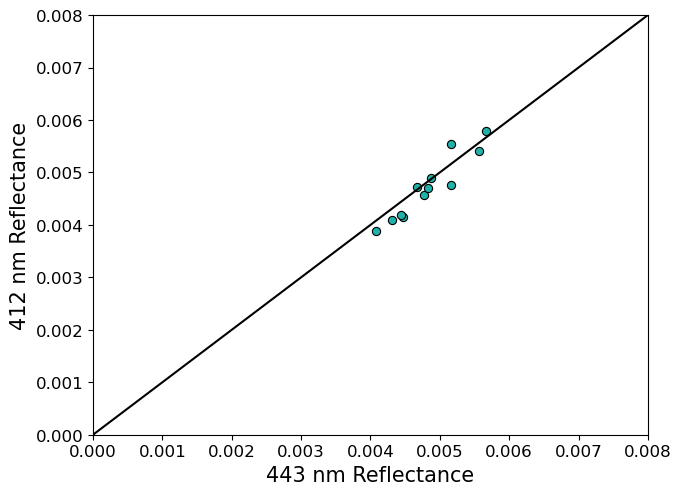

In [89]:
basefile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/2022*MODIS_L2_ratios.nc')
basefile.sort()

fig, ax = plt.subplots(figsize=(6.6, 5))

timelist = []

for file in basefile:
    
    basefile1 = file.split('/')[6][0:7]
    timelist.append(basefile1)
    

ameans = []
bmeans = []
    
for file in timelist:  

    bds = xr.open_dataset('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/'+ file +'_MODIS_L2_ratios.nc')


    adata = bds.WL443.mean('time')
    trueadata = adata.where(adata!=0)
    amean = trueadata.mean(dim=['x', 'y'])
    ameans.append(amean)

    bdata = bds.WL412.mean('time')
    truebdata = bdata.where(bdata!=0)
    bmean = truebdata.mean(dim=['x', 'y'])
    bmeans.append(bmean)


ax.axline((0, 0), slope=1, color='k')

plt.scatter(ameans, bmeans, s=35, c='lightseagreen', edgecolors='k', linewidth=0.8)


# ax.annotate('the top',
#             xy=(np.pi/2., 10.),      # theta, radius
#             xytext=(np.pi/3, 20.),   # theta, radius
#             xycoords='polar',
#             textcoords='polar',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='left',
#             verticalalignment='bottom',
#             clip_on=True)
plt.xlabel('443 nm Reflectance', size=15)
plt.ylabel('412 nm Reflectance', size=15)
plt.tight_layout()
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 0.008)
plt.ylim(0, 0.008)
plt.savefig('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/JBTask/443by412Scatterplot.png', bbox_inches='tight')

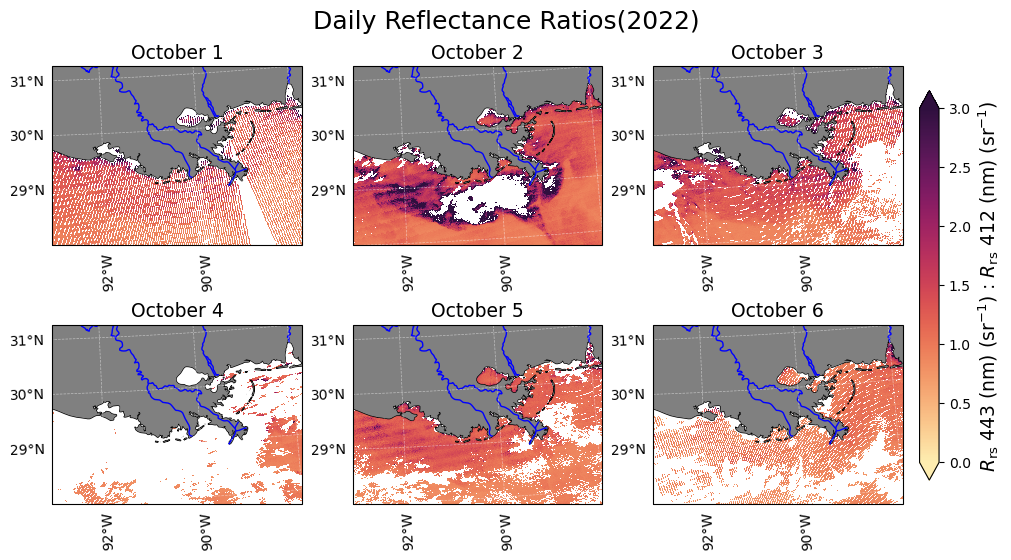

In [23]:
###ratio

# cfile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/2022*MODIS_L2_ratios.nc')
cfile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/OCT2022*MODIS_L2_ratios.nc')
cfile.sort()

lat_top=31
lat_bot=28
lon_left=-93
lon_rigth=-88
extent=[lon_left, lon_rigth, lat_bot, lat_top]

resval = 1000 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
res = xr.DataArray(resval, attrs={"units": "meters"})

projection = ccrs.PlateCarree()

fig, axgr = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 5.5),
                             subplot_kw={'projection':ccrs.LambertConformal()})

# fig, axgr = plt.subplots(2, 6, constrained_layout=True, figsize=(19.5, 5.5),
#                              subplot_kw={'projection':ccrs.LambertConformal()})
        

# title = ['January 2022', 'February 2022', 'March 2022', 'April 2022', 'May 2022', 'June 2022',
#          'July 2022', 'August 2022', 'September 2022', 'October 2022', 'November 2022', 'December 2022']
title = ['October 1', 'October 2', 'October 3', 'October 4', 'October 5', 'October 6']


for i, ax in enumerate(axgr.flatten()):
    try:
        ds = xr.open_dataset(cfile[i])
        data = ds.ratio.mean('time')

        im = data.where(data!=0).plot(ax=ax, vmin=0, vmax=3, 
                                      x='lon', y='lat', 
                                      add_colorbar=False,
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmo.matter)
        ax.coastlines()
        ax.set_extent(extent)
        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                    name='land',
                                                    facecolor='grey', # change color here
                                                    scale='10m')) 
        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                    name='rivers_lake_centerlines',
                                                    edgecolor='blue', # change color here
                                                    facecolor='none',
                                                scale='10m'))
        gl = ax.gridlines(crs=ccrs.PlateCarree(),
             ylocs=[28, 29, 30, 31], 
             xlocs=[-94, -92, -90, -88], 
             draw_labels=True, linewidth=0.5, color='w', alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
        gl.right_labels = False
        gl.top_labels = False
        ax.set_title(title[i], fontsize=13.5)
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Longitude')
        
        
    except:
        ax.remove()
        pass
    
fig.suptitle('Daily Reflectance Ratios (2022)', size=18)
cb = fig.colorbar(im, ax=axgr, shrink=0.8, extend='both', pad=0.02)
cb.set_label('$R_{\mathrm{rs}}$ 443 (nm) (sr$^{-1}$) : $R_{\mathrm{rs}}$ 412 (nm) (sr$^{-1}$)', size=13.5)
fig.savefig('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/JBTask/DailyWLRatios.png')

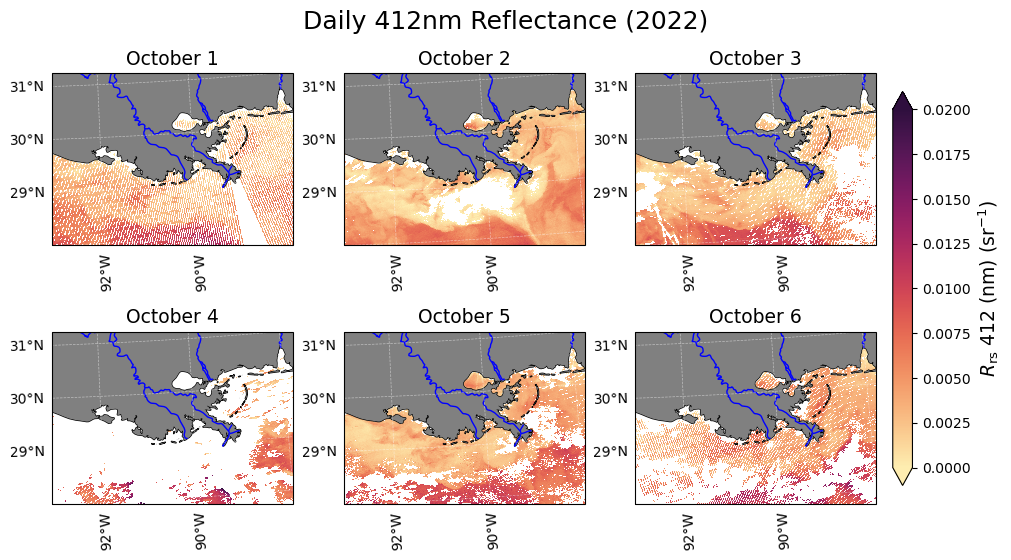

In [24]:
###412 nm

# cfile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/2022*MODIS_L2_ratios.nc')
cfile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/OCT2022*MODIS_L2_ratios.nc')

cfile.sort()

lat_top=31
lat_bot=28
lon_left=-93
lon_rigth=-88
extent=[lon_left, lon_rigth, lat_bot, lat_top]

resval = 1000 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
res = xr.DataArray(resval, attrs={"units": "meters"})

projection = ccrs.PlateCarree()

fig, axgr = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 5.5),
                             subplot_kw={'projection':ccrs.LambertConformal()})

# fig, axgr = plt.subplots(2, 6, constrained_layout=True, figsize=(19.5, 5.5),
#                              subplot_kw={'projection':ccrs.LambertConformal()})

# title = ['January 2022', 'February 2022', 'March 2022', 'April 2022', 'May 2022', 'June 2022',
#          'July 2022', 'August 2022', 'September 2022', 'October 2022', 'November 2022', 'December 2022']
title = ['October 1', 'October 2', 'October 3', 'October 4', 'October 5', 'October 6']



for i, ax in enumerate(axgr.flatten()):
    try:
        ds = xr.open_dataset(cfile[i])
        data = ds.WL412.mean('time')

        im = data.where(data!=0).plot(ax=ax, vmin=0, vmax=0.02, 
                                      x='lon', y='lat', 
                                      add_colorbar=False,
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmo.matter)
        ax.coastlines()
        ax.set_extent(extent)
        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                    name='land',
                                                    facecolor='grey', # change color here
                                                    scale='10m')) 
        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                    name='rivers_lake_centerlines',
                                                    edgecolor='blue', # change color here
                                                    facecolor='none',
                                                scale='10m'))
        gl = ax.gridlines(crs=ccrs.PlateCarree(),
             ylocs=[28, 29, 30, 31], 
             xlocs=[-94, -92, -90, -88], 
             draw_labels=True, linewidth=0.5, color='w', alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
        gl.right_labels = False
        gl.top_labels = False
        ax.set_title(title[i], fontsize=13.5)
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Longitude')
        
        
    except:
        ax.remove()
        pass
    
fig.suptitle('Daily 412nm Reflectance (2022)', size=18)
cb = fig.colorbar(im, ax=axgr, shrink=0.8, extend='both', pad=0.02)
cb.set_label('$R_{\mathrm{rs}}$ 412 (nm) (sr$^{-1}$)', size=13.5)
fig.savefig('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/JBTask/DailyWL412.png')

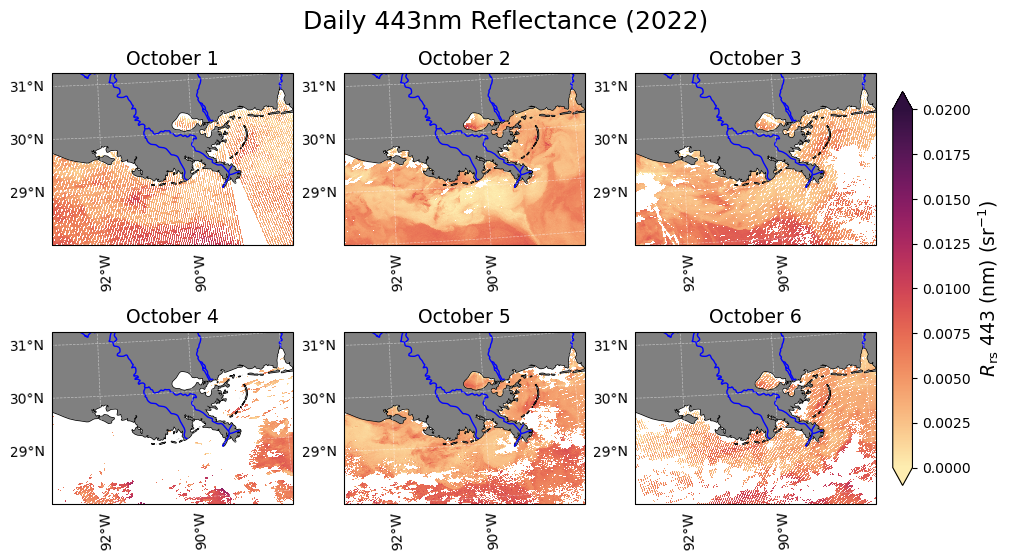

In [25]:
###443 nm

# cfile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/2022*MODIS_L2_ratios.nc')
cfile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/OCT2022*MODIS_L2_ratios.nc')
cfile.sort()

lat_top=31
lat_bot=28
lon_left=-93
lon_rigth=-88
extent=[lon_left, lon_rigth, lat_bot, lat_top]

resval = 1000 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
res = xr.DataArray(resval, attrs={"units": "meters"})

projection = ccrs.PlateCarree()

fig, axgr = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 5.5),
                             subplot_kw={'projection':ccrs.LambertConformal()})

# fig, axgr = plt.subplots(2, 6, constrained_layout=True, figsize=(19.5, 5.5),
#                              subplot_kw={'projection':ccrs.LambertConformal()})

# title = ['January 2022', 'February 2022', 'March 2022', 'April 2022', 'May 2022', 'June 2022',
#          'July 2022', 'August 2022', 'September 2022', 'October 2022', 'November 2022', 'December 2022']
title = ['October 1', 'October 2', 'October 3', 'October 4', 'October 5', 'October 6']



for i, ax in enumerate(axgr.flatten()):
    try:
        ds = xr.open_dataset(cfile[i])
        data = ds.WL443.mean('time')

        im = data.where(data!=0).plot(ax=ax, vmin=0, vmax=0.02, 
                                      x='lon', y='lat', 
                                      add_colorbar=False,
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmo.matter)
        ax.coastlines()
        ax.set_extent(extent)
        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                    name='land',
                                                    facecolor='grey', # change color here
                                                    scale='10m')) 
        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                    name='rivers_lake_centerlines',
                                                    edgecolor='blue', # change color here
                                                    facecolor='none',
                                                scale='10m'))
        gl = ax.gridlines(crs=ccrs.PlateCarree(),
             ylocs=[28, 29, 30, 31], 
             xlocs=[-94, -92, -90, -88], 
             draw_labels=True, linewidth=0.5, color='w', alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
        gl.right_labels = False
        gl.top_labels = False
        ax.set_title(title[i], fontsize=13.5)
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Longitude')
        
        
    except:
        ax.remove()
        pass
    
fig.suptitle('Daily 443nm Reflectance (2022)', size=18)
cb = fig.colorbar(im, ax=axgr, shrink=0.8, extend='both', pad=0.02)
cb.set_label('$R_{\mathrm{rs}}$ 443 (nm) (sr$^{-1}$)', size=13.5)
fig.savefig('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/JBTask/DailyWL443.png')

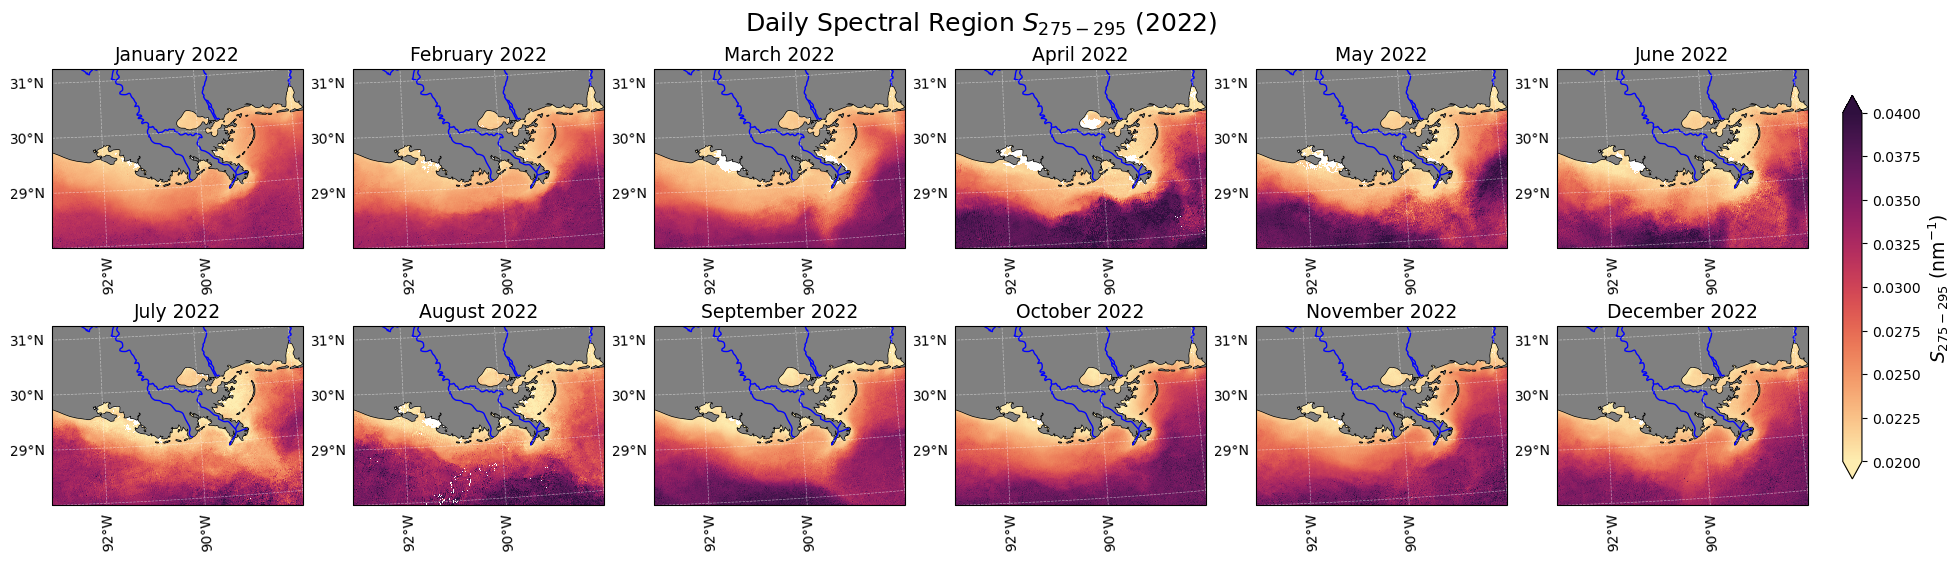

In [18]:
###S275-295

cfile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/2022*MODIS_L2_ratios.nc')
# cfile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/OCT2022*MODIS_L2_ratios.nc')
cfile.sort()

lat_top=31
lat_bot=28
lon_left=-93
lon_rigth=-88
extent=[lon_left, lon_rigth, lat_bot, lat_top]

resval = 1000 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
res = xr.DataArray(resval, attrs={"units": "meters"})

projection = ccrs.PlateCarree()

# fig, axgr = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 5.5),
#                              subplot_kw={'projection':ccrs.LambertConformal()})

fig, axgr = plt.subplots(2, 6, constrained_layout=True, figsize=(19.5, 5.5),
                             subplot_kw={'projection':ccrs.LambertConformal()})


title = ['January 2022', 'February 2022', 'March 2022', 'April 2022', 'May 2022', 'June 2022',
         'July 2022', 'August 2022', 'September 2022', 'October 2022', 'November 2022', 'December 2022']
# title = ['October 1', 'October 2', 'October 3', 'October 4', 'October 5', 'October 6']



for i, ax in enumerate(axgr.flatten()):
    try:
        ds = xr.open_dataset(cfile[i])
        data = ds.S275_295.mean('time')

        im = data.where(data!=0).plot(ax=ax, vmin=0.02, vmax=0.04, 
                                      x='lon', y='lat', 
                                      add_colorbar=False,
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmo.matter)
        ax.coastlines()
        ax.set_extent(extent)
        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                    name='land',
                                                    facecolor='grey', # change color here
                                                    scale='10m')) 
        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                    name='rivers_lake_centerlines',
                                                    edgecolor='blue', # change color here
                                                    facecolor='none',
                                                scale='10m'))
        gl = ax.gridlines(crs=ccrs.PlateCarree(),
             ylocs=[28, 29, 30, 31], 
             xlocs=[-94, -92, -90, -88], 
             draw_labels=True, linewidth=0.5, color='w', alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
        gl.right_labels = False
        gl.top_labels = False
        ax.set_title(title[i], fontsize=13.5)
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Longitude')
        
        
    except:
        ax.remove()
        pass
    
fig.suptitle('Daily Spectral Region $S_{\mathrm{275-295}}$ (2022)', size=18)
cb = fig.colorbar(im, ax=axgr, shrink=0.8, extend='both', pad=0.02)
cb.set_label('$S_{\mathrm{275-295}}$ (nm$^{-1}$)', size=13.5)
fig.savefig('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/JBTask/2022S275_295.png')

(array([[  0.,  23.,  35., ...,   1.,   0.,   0.],
        [  1.,  18.,  35., ...,   9.,   0.,   0.],
        [  0.,   8.,  40., ...,   6.,   0.,   0.],
        ...,
        [  0.,   0.,   1., ..., 112.,   3.,   0.],
        [  0.,   0.,   0., ..., 118.,   0.,   0.],
        [  0.,   0.,   0., ..., 107.,   1.,   0.]]),
 array([0.01828637, 0.02081457, 0.02334276, 0.02587096, 0.02839915,
        0.03092735, 0.03345554, 0.03598374, 0.03851193, 0.04104013,
        0.04356832], dtype=float32),
 <a list of 542 BarContainer objects>)

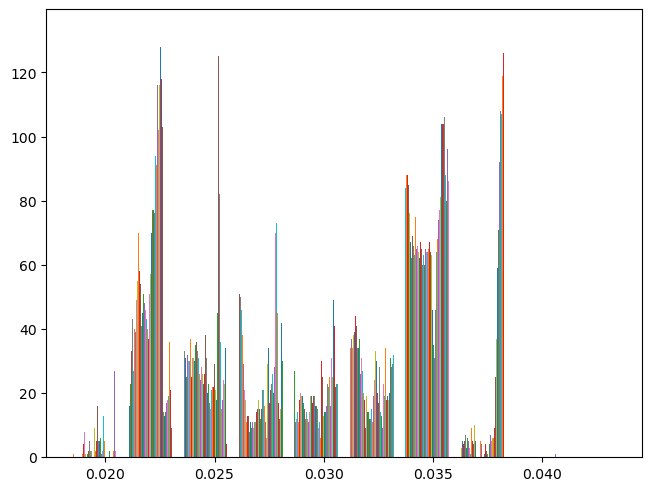

In [17]:
cfile = glob('/home/hboi-ouri/Projects/RS_Files/JBTaskRatio/2022*MODIS_L2_ratios.nc')
cfile.sort()

lat_top=31
lat_bot=28
lon_left=-93
lon_rigth=-88
extent=[lon_left, lon_rigth, lat_bot, lat_top]

resval = 1000 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
res = xr.DataArray(resval, attrs={"units": "meters"})

projection = ccrs.PlateCarree()

fig, axgr = plt.subplots(1, 1, constrained_layout=True)



ds = xr.open_dataset(cfile[2])
data = ds.S275_295.mean('time')

axgr.hist(data.where(data!=0))